# 0. Importaciones

A continuación se importan diversas librerías útiles para el manejo de los datos y la visualización de los resultados.

In [ ]:
sns.set() # Establece el estilo de las gráficas

Específicas de Pytorch se necesita:

**torch.nn:** para crear el modelo de red neuronal.

**torch.autograd:** se necesita el módulo Variable, que se encarga de manejar las operaciones de los tensores.

**torch.optim:**  se necesita el optimizador para entrenar la red neuronal y modificar sus pesos.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.model_selection import train_test_split   #permite dividir conjuntos de datos en train y test
from pathlib import Path
import imageio.v2 as imageio
from IPython.display import Image, display
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

# 1. Ejemplo de la clasificación para el problema XOR

Para poder definir una Red Neuronal Artificial(_MLP_ por sus siglas en inglés) haremos uso de la librería Pytorch. Esta librería permite dar nuevas funcionalidades a una clase estándar de Python (tal y como ocurría con las dataclasses). En concreto nos interesa definir dos funciones para esta clase:

*   *init*: Se definen las capas de las que consta el modelo,
*   *forward*: Se especifica el proceso de la propagación hacia adelante, desde la entrada hasta la capa de salida.

Veamos un pequeño ejemplo con el Perceptron para el problema de la separación del XOR. En primer lugar definiremos y mostraremos los datos, para lo cuál definimos la siguiente función.

In [ ]:
def mostrar(datos, eje_x, eje_y, nombre_clases=[]):
    """Muestra una gráfica de puntos utilizando para ello los datos de la
    características que se solicitan como parámetro.

    Nota: El parámetro hue nos sirve para cambiar el aspecto de la gráfica en función del
    # valor que toma en una columna en concreto.
    """
    if len(nombre_clases) == len(datos["target"].unique()):
      sns.scatterplot(data=datos, x=eje_x, y=eje_y, hue=nombre_clases[datos["target"]], palette="tab10")
    else:
      sns.scatterplot(data=datos, x=eje_x, y=eje_y, hue=datos["target"], palette="tab10")


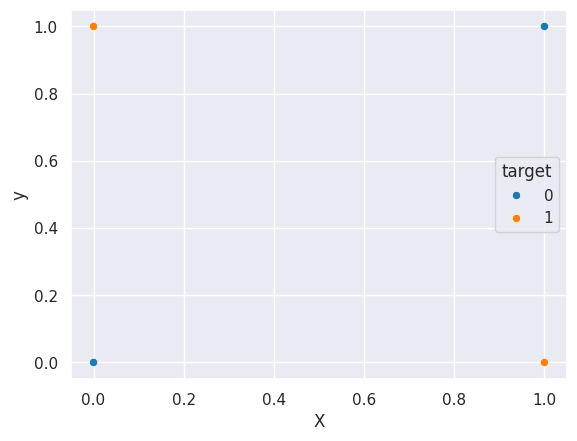

In [ ]:
xor = pd.DataFrame({
    "X": [0.,0., 1., 1.],
    "y": [0.,1.,0.,1.],
    "target": [0, 1, 1, 0]
})

mostrar(xor, "X", "y")
entrada = torch.tensor(xor[["X", "y"]].values, dtype=torch.float32) # .values nos da la representación de numpy
salida = torch.tensor(xor["target"].values, dtype=torch.long)

In [ ]:
class Perceptron(nn.Module):
    def __init__(self):
        """
        En init suele añadirse el número de características que tiene el dataset,
        en este caso concreto, al ser el problema del xor, utilizamos 2 por defecto
        """
        super(Perceptron, self).__init__()
        self.capa1 = nn.Linear(2, 2) # Importante, el 2 inicial representa el nº de características de nuestro dataset. Esta capa se corresponde con la de la entrada.

    def forward(self, entrada):
        salida = self.capa1(entrada)
        probabilidades = F.softmax(salida, dim=1)
        return probabilidades

Veamos visualmente qué aspecto tiene la red.

In [ ]:
from IPython.display import IFrame

IFrame(src=f"https://drive.google.com/file/d/1hOqOdnk6lQphQgHdJA6bksVWzQOgOeb5/preview", width=640, height=480)


Como puede observar en la función **init** de la clase **Perceptron** tenemos diferenciados dos atributos, *capa1* y *soft*. El primero de ellos permitirá realizar una transformación lineal de los datos de entrada. El segundo resulta de gran utilidad, ya que transforma la salida a valores que están en el intervalo $[0,1]$. De este modo, la suma de todos los valores será *exactamente* $1$. Esto es así debido a que estamos representando probabilidades. Luego, en cada índice tendremos valores que representan la probabilidad de que pertenezca a la $i-$ésima clase.

Tras esto, podemos definir el resto de elementos necesarios. El optimizador, la función de pérdida y nuestro bucle para realizar el entrenamiento del modelo. Recuerda que para la función de pérdida ($loss$), depende en gran medida del tipo de tarea de queremos que realice la red. Por ejemplo, para realizar una regresión podemos utilizar el error cuadrático medio ($MSE$), mientras que para la clasificación suele usarse la $CrossEntropyLoss$. Por el momento, familiarícese sólo con su uso, sin entrar en más detalle.

En cuanto al optimizador, se utilizará el Descenso de Gradiente Estocástico (SGD), con una tasa de aprendizaje de $0.01$.

In [ ]:
def train(modelo, entrada, salida, epochs):
    for epoch in range(epochs):
        # 1. Reseteamos el gradiente
        optimizador.zero_grad()
        # 2. Obtenemos la salida del modelo. Propagación hacia adelante
        prediccion = modelo(entrada)
        # 3. Obtención del error
        error = f_perdida(prediccion, salida)
        # 4. Propagamos el error hacia atrás, actualizando los pesos
        error.backward()
        optimizador.step()
    return modelo

perceptron = Perceptron()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(perceptron.parameters(), lr=0.01) # En lr especificamos la tasa de aprendizaje (η).
epochs = 1000
train(perceptron, entrada, salida, epochs)

Perceptron(
  (capa1): Linear(in_features=2, out_features=2, bias=True)
)

Si queremos obtener la predicción del modelo para un dato concreto, podemos hacer una llamada al modelo como si fuese una función. Sin embargo, verá que no es muy descriptiva.

In [ ]:
y_hat = perceptron(torch.Tensor([[1., 1.]]))
print(y_hat)

tensor([[0.5646, 0.4354]], grad_fn=<SoftmaxBackward0>)


Para devolver la clase 0 o 1, se usa la función argmax, que devuelve la posición del máximo. Dicho de otro modo, la clase **más probable**.

In [ ]:
print(torch.argmax(y_hat))

tensor(0)


¿Qué valor predice para el punto $(1, 1)$. ¿Sería correcto? Pruebe con algún punto más.

El punto (1,1) pertenece a la clase '0'. Por lo que después de entrenarse debería de devolver una clase de salida será cercana a 0. Esto es debido a que estamos haciendo uso de XOR (Exclusive OR), por tanto, si ambas entradas son iguales (ambas son 0 o 1) devolverá falso, es decir 0. En caso contrarío devolveria 1.

Si probamos con el punto (0,1), debería de devolver una clase de salida 1, debido a la naturaleza del XOR.

In [ ]:
y_hat = perceptron(torch.Tensor([[0, 1]]))
print(y_hat)

tensor([[0.5433, 0.4567]], grad_fn=<SoftmaxBackward0>)


In [ ]:
print(torch.argmax(y_hat))

tensor(0)


Como vemos, de igual manera nos sale 0, esto es debido a que el perceptrón están básico que da el resultado incorrecto.

Esto sucede porque el perceptrón ha tenido que aprender a partir de 4 puntos (0,0), (0,1), (1,0) y (1,1) lo cual no es suficiente. Además nada más de obtener el primer punto 'x' intenta predecir la salida, lo cual no es útil ni correcto.

Ahora bien, recuerde que el Perceptron básico no nos permite clasificar clases que no sean linealmente separables. Es el caso del problema del XOR. Para visualizar qué está pasando internamente con la red, vamos a crear un par de funciones que ayuden a la visualización.

In [ ]:
def plot_decision_boundary(model, X, y, epoch):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    with torch.no_grad():
        Z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()).detach().numpy()
        Z = torch.softmax(torch.from_numpy(Z), dim=1).numpy()[:, 1]
    Z = Z.reshape(xx.shape)

    contour = plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k', cmap=plt.cm.Spectral)
    cbar = plt.colorbar(contour)
    cbar.set_label('Probabilidad de la clase #1')

    plt.title(f"Epoch {epoch}")
    plt.savefig(f'./imgs/frontera_decision_{epoch}.png')
    plt.close()

Vamos a crear un _gif_, para lo cual, en primer lugar vamos a crear el directorio en el que vamos a crear las imágenes. Para ver las imágenes, puede hacer click en el icono de la carpeta y ahí verá las imágenes según se irán generando.

In [ ]:
directorio = Path("imgs")
directorio.mkdir(exist_ok=True)

Y tras esto, vamos a modificar levemente el bucle del entrenamiento.

In [ ]:
def train(modelo, entrada, salida, epochs):
    for epoch in range(epochs):
        # 1. Reseteamos el gradiente
        optimizador.zero_grad()
        # 2. Obtenemos la salida del modelo. Propagación hacia adelante
        prediccion = modelo(entrada)
        # 3. Obtención del error
        error = f_perdida(prediccion, salida)
        # 4. Propagamos el error hacia atrás, actualizando los pesos
        error.backward()
        optimizador.step()
        if epoch % 10 == 0: # Sólo vamos a guardar una imagen cada 10 épocas
            plot_decision_boundary(modelo, entrada, salida, epoch)
    return modelo

Entrenemos el modelo y obtengamos las imágenes.

In [ ]:
perceptron = Perceptron()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(perceptron.parameters(), lr=0.01) # En lr especificamos la tasa de aprendizaje.
epochs = 1000
train(perceptron, entrada, salida, 1000)

Perceptron(
  (capa1): Linear(in_features=2, out_features=2, bias=True)
)

In [ ]:
imagenes = []
for epoch in tqdm(range(1000)):
    if epoch % 10 == 0:
        imagenes.append(imageio.imread(f'./imgs/frontera_decision_{epoch}.png'))

imageio.mimsave('./imgs/frontera_decision.gif', imagenes, fps=15, loop=0)

100%|██████████| 1000/1000 [00:01<00:00, 743.94it/s]


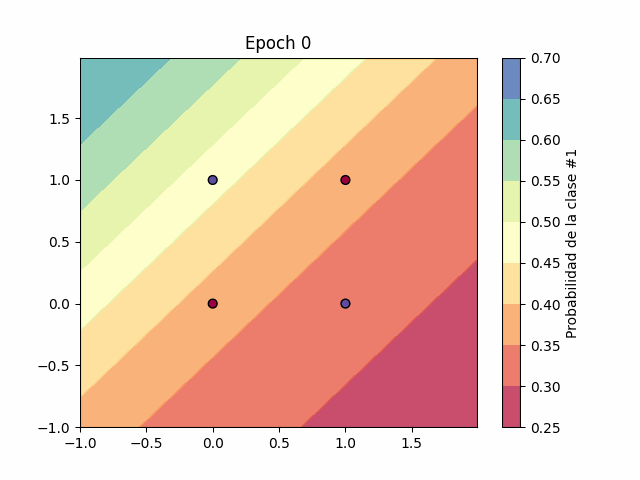

In [ ]:
imagen = Image("imgs/frontera_decision.gif")
display(imagen)

¿Qué ocurre si en lugar de conectar la entrada con la salida, agregamos una capa adicional (denominada capa oculta), e incorporamos una función de activación como ReLU?

ReLU o [rectificador](https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)) nos permite introducir no linealidad en la red neuronal, esta opera emitiendo directamente la salida si es positiva; de lo contrario (es negativa) emite 0. Siendo la fórmula de ReLU -> $ReLU(x)=max(0,x)$

Por otro lado, la [capa oculta](https://es.statisticseasily.com/glossario/what-is-hidden-layer/) se ubica entre la capa de entrada y la capa de salida y pueden haber tantas cuantas queramos. Estas capas desempeñan un papel crucial en la transformación de los datos de entrada en un formato que la red puede utilizar para hacer predicciones o clasificaciones.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        """
        En init suele añadirse el número de características que tiene el dataset,
        en este caso concreto, al ser el problema del xor, utilizamos 2 por defecto
        """
        super(MLP, self).__init__()

        self.capa1 = nn.Linear(2, 8) # Importante, el 2 inicial representa el nº de características de nuestro dataset
        self.activacion = nn.ReLU()
        self.capa2 = nn.Linear(8, 2)

    def forward(self, entrada):
        salida_capa1 = self.activacion(self.capa1(entrada))
        salida = self.capa2(salida_capa1)
        return salida

red = MLP()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(red.parameters(), lr=0.01, momentum=0.9) # Momentum es un parámetro para que converja más rápido.
epochs = 1000
train(red, entrada, salida, 1000)

imagenes = []
for epoch in tqdm(range(1000)):
    if epoch % 10 == 0:
        imagenes.append(imageio.imread(f'./imgs/frontera_decision_{epoch}.png'))

imageio.mimsave('./imgs/frontera_decision2.gif', imagenes, fps=15, loop=0)

100%|██████████| 1000/1000 [00:00<00:00, 1326.55it/s]


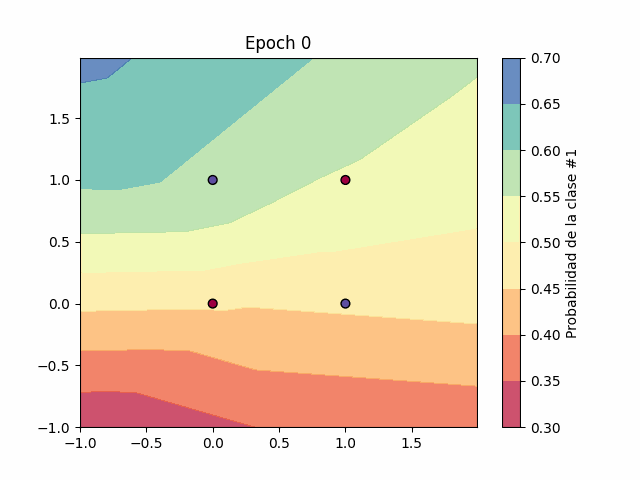

In [ ]:
imagen = Image("imgs/frontera_decision2.gif")
display(imagen)

Pruebe con otras funciones de activación en lugar de ReLU y observe qué ocurre.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        """
        En init suele añadirse el número de características que tiene el dataset,
        en este caso concreto, al ser el problema del xor, utilizamos 2 por defecto
        """
        super(MLP, self).__init__()

        self.capa1 = nn.Linear(2, 8) # Importante, el 2 inicial representa el nº de características de nuestro dataset
        self.activacion = nn.Tanh()# Incluya otra función de activación Tanh, Sigmoid, ...
        self.capa2 = nn.Linear(8, 2)

    def forward(self, entrada):
        salida_capa1 = self.activacion(self.capa1(entrada))
        salida = self.capa2(salida_capa1)
        return salida

red = MLP()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(red.parameters(), lr=0.01, momentum=0.9) # Momentum es un parámetro para que converja más rápido.
epochs = 1000
train(red, entrada, salida, 1000)

imagenes = []
for epoch in tqdm(range(1000)):
    if epoch % 10 == 0:
        imagenes.append(imageio.imread(f'./imgs/frontera_decision_{epoch}.png'))

imageio.mimsave('./imgs/frontera_decision3.gif', imagenes, fps=15, loop=0)

100%|██████████| 1000/1000 [00:00<00:00, 1195.92it/s]


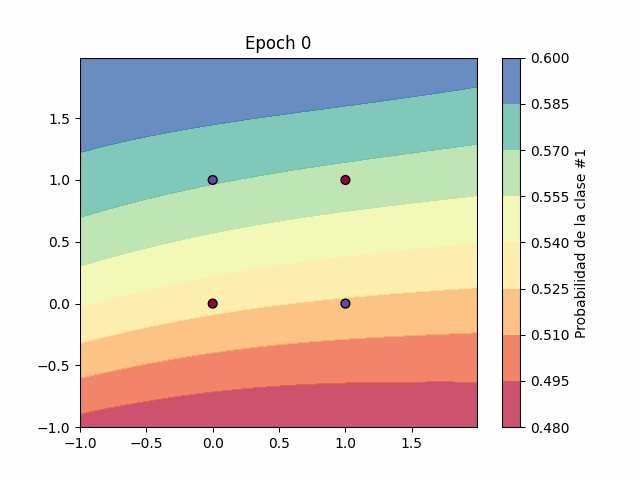

In [ ]:
imagen = Image("imgs/frontera_decision3.gif")
display(imagen)

### Pregunta 1:
¿Tiene sentido cambiar el número de unidades en la capa de salida?
¿Y en la capa oculta?

Dependiendo de la tarea que estemos realizando si tiene sentido cambiar el número de unidades de la capa de salida, ya que esta se tiene que ajustar al número de clases que queremos predecir.

Por otro lado, también tiene sentido cambiar el número de capas ocultas, ya que esto repercute en la transformación de los datos de entrada.

Por tanto, en el primer caso, el número de unidades en la capa de salida debe de coincidir con el número de clases a predecir y en las capas ocultas a mayor número la transformación de los datos puede mejorar.

# 2. Clasificación para la base de datos Iris

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris(as_frame=True) # Vamos a cargarlo como un DataFrame de la librería Pandas
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

Ahora unamos las entradas y salidas en un único dataset llamado __iris__ y exploremos qué forma tiene el dataset.

In [ ]:
iris = pd.concat([X, y], axis=1)

In [ ]:
iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


¿Qué rango de valores tiene este dataset? Para ello, podemos usar la función _describe_ que nos da información muy útil que podríamos utilizar a posteriori.

In [ ]:
iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [ ]:
iris.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

También es útil ver a nivel gráfico qué forma tienen los datos. Para ello, podemos utilizar la librería seaborn, la cual está orientada a hacer gráficas de forma sencilla usando DataFrames de Pandas. Veamos un pequeño ejemplo con las dos primeras características de Iris: la longitud y el ancho del sépalo.

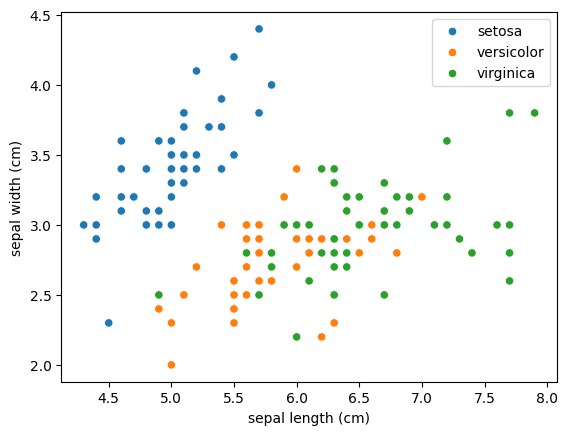

In [ ]:
mostrar(iris, "sepal length (cm)", "sepal width (cm)", names)

¿Cómo mostraríamos las dos últimas características, el alto y el ancho del pétalo?

Para mostrar ambas características podemos guiarnos por la consulta anterior y haciendo uso de los dos últimos parámetros del "Index".

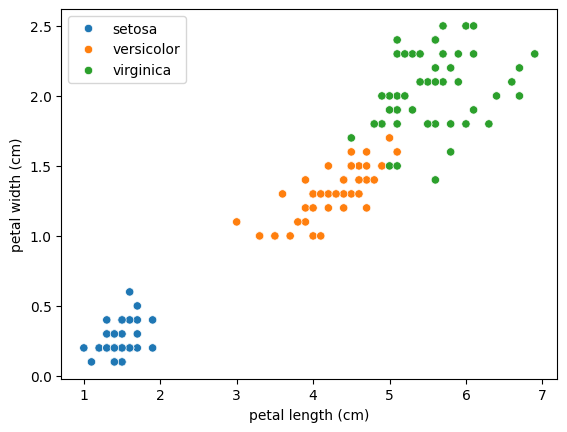

In [ ]:
mostrar(iris, "petal length (cm)", "petal width (cm)", names)

También puede comprobar cómo se distribuyen los valores teniendo en cuenta cada par de características

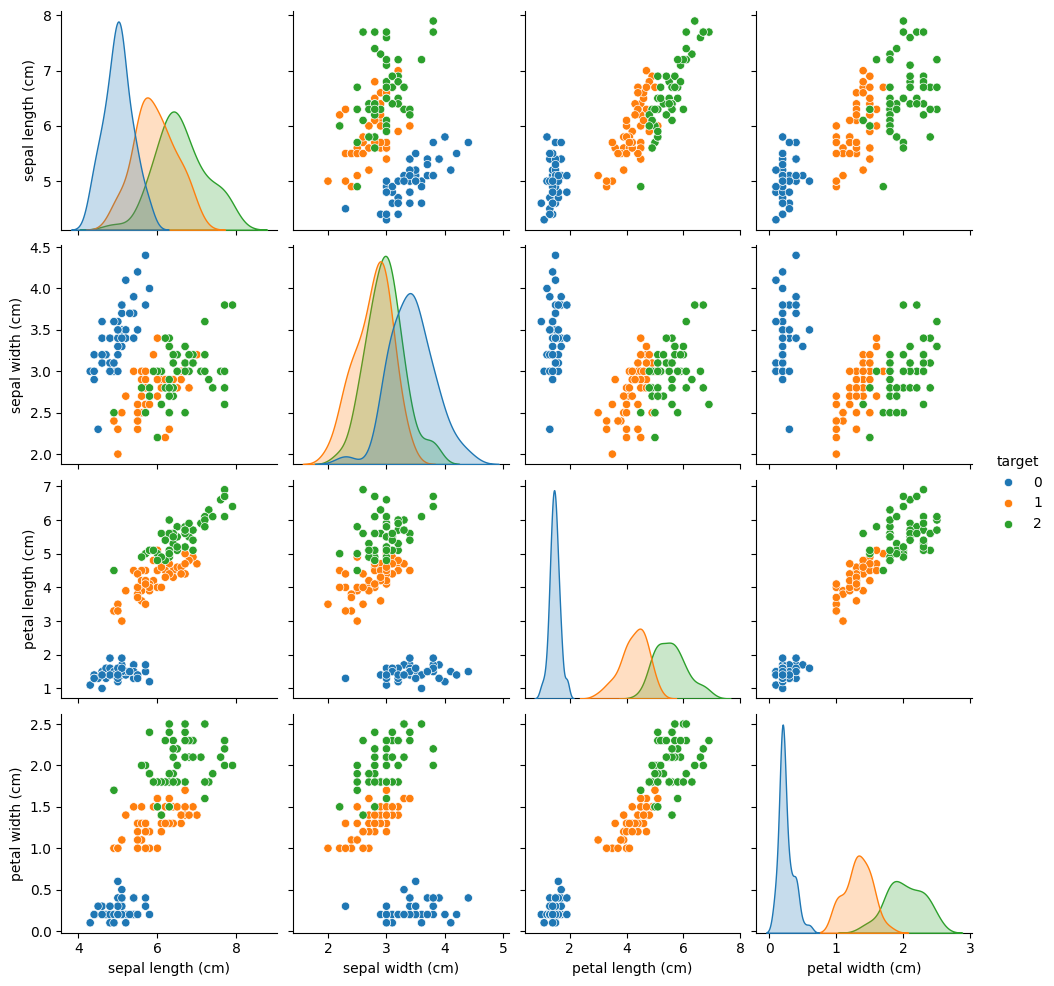

In [ ]:
sns.pairplot(iris, hue="target", palette="tab10")

## 2.1 Preprocesado
Cuando estamos trabajando con modelos de Aprendizaje Automático (_Machine Learning_) casi siempre es recomendable realizar algún tipo de preprocesamiento. Uno de los más habituales es realizar un escalado para que los datos estén en una distribución normal, es decir, con media ($\mu$) 0 y varianza ($\sigma$) 1. Para ello se sigue la siguiente fórmula:

$$ X = \frac{X - X_{media}}{X_{desviacion\_tipica}} $$

Es decir, a cada elemento del dataset se le resta la media del conjunto completo y tras esto, se divide por la desviación típica. Teniendo en cuenta que las aplicaciones aritméticas se aplican sobre el dataframe completo, hacemos la siguiente transformación.

In [ ]:
iris_standard = iris.copy()
iris_standard[iris.columns[:-1]] = (iris_standard[iris.columns[:-1]] - iris_standard[iris.columns[:-1]].mean()) / iris_standard[iris.columns[:-1]].std()
iris_standard.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02,150.000000
mean,-5.210647e-16,-7.579123e-16,-2.842171e-16,-3.789561e-16,1.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.819232
min,-1.863780e+00,-2.425820e+00,-1.562342e+00,-1.442245e+00,0.000000
25%,-8.976739e-01,-5.903951e-01,-1.222456e+00,-1.179859e+00,0.000000
50%,-5.233076e-02,-1.315388e-01,3.353541e-01,1.320673e-01,1.000000
75%,6.722490e-01,5.567457e-01,7.602115e-01,7.880307e-01,2.000000
max,2.483699e+00,3.080455e+00,1.779869e+00,1.706379e+00,2.000000


Importante, como ha podido comprobar no hemos modificado la variable de salida. Sólo las variables de entrada, de ahí el uso de iris.columns[:-1]. Esto devuelve el nombre de todas las columnas menos el de la última.

Muestre los datos como en el ejemplo anterior. ¿Aprecia alguna diferencia?

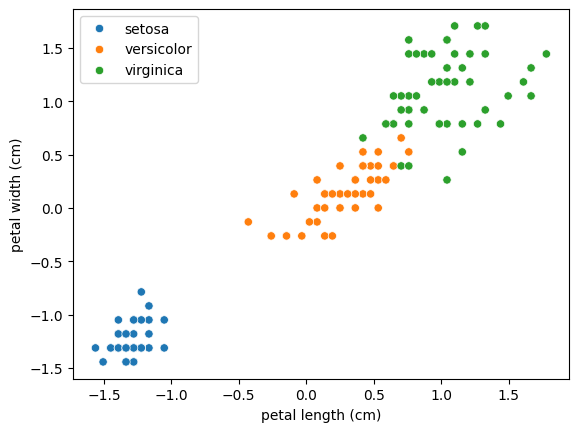

In [ ]:
mostrar(iris_standard,"petal length (cm)", "petal width (cm)", names)

Si comparamos con el mostrar con "iris" vemos que el intervalo es mucho menor, pasamos de (0.0 , 2.5) a (-1.5, 1.5).

Otro tipo de preprocesado alternativo y habitual es realizar un escalado para que todos los datos se encuentren en un intervalo $[0,1]$. Para realizar este preprocesado se realiza la siguiente operación.

$$ X = \frac{X - X_{min}}{X_{max} - X_{min}} $$

In [ ]:
iris_01 = iris.copy()
iris_01[iris.columns[:-1]] = (iris_01[iris.columns[:-1]] - iris_01[iris.columns[:-1]].min()) /  \
                             (iris_01[iris.columns[:-1]].max() - iris_01[iris.columns[:-1]].min())
iris_01.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.440556,0.467458,0.458056,1.000000
std,0.230018,0.181611,0.299203,0.317599,0.819232
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333,0.000000
50%,0.416667,0.416667,0.567797,0.500000,1.000000
75%,0.583333,0.541667,0.694915,0.708333,2.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000


Muestre los datos como en el ejemplo anterior. ¿Aprecia alguna diferencia?

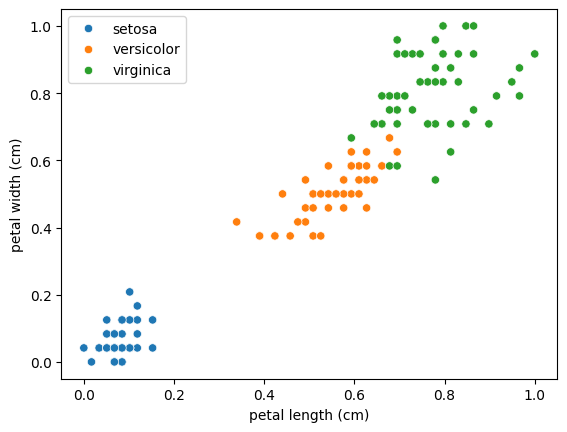

In [ ]:
mostrar(iris_01, "petal length (cm)", "petal width (cm)", names)

Si comparamos con el mostrar de "iris_standard" vemos que ahora el intervalo es (0, 1).

Esta es una demostración de distintas formas de preprocesar los datos de entrada. Normalmente, no se trata con dataframes de pandas en todo momento, si no que se opta por trabajar con la matriz directamente, ya que resulta más cómodo.

Toda esta exploración inicial de los datos, suele formar parte de un proceso más amplío que se sigue en proyectos de este ámbito conocido como Análisis Exploratorio de Datos (*EDA* por sus siglas en inglés). Así, se pueden tener "pistas" que ayuden o guíen en la resolución del problema.

In [ ]:
iris = iris.values
iris_scaled = iris.copy() # Obtenemos la matriz de numpy a partir del DataFrame

In [ ]:
iris_scaled[:, :-1] = torch.Tensor((iris_scaled[:, :-1] - iris_scaled[:, :-1].max()) / (iris_scaled[:, :-1].max() - iris_scaled[:, :-1].min()))

In [ ]:
print(iris_scaled[0:10]) # Imprimimos las 10 primeras filas

[[-0.35897437 -0.56410259 -0.83333331 -0.98717946  0.        ]
 [-0.38461539 -0.62820512 -0.83333331 -0.98717946  0.        ]
 [-0.41025642 -0.6025641  -0.84615386 -0.98717946  0.        ]
 [-0.42307693 -0.61538464 -0.82051283 -0.98717946  0.        ]
 [-0.37179488 -0.55128205 -0.83333331 -0.98717946  0.        ]
 [-0.32051283 -0.51282054 -0.79487181 -0.96153843  0.        ]
 [-0.42307693 -0.57692307 -0.83333331 -0.97435898  0.        ]
 [-0.37179488 -0.57692307 -0.82051283 -0.98717946  0.        ]
 [-0.44871795 -0.64102566 -0.83333331 -0.98717946  0.        ]
 [-0.38461539 -0.61538464 -0.82051283 -1.          0.        ]]


# 3. Entrenamiento del modelo

Una vez familiarizado con cómo funciona Pytorch, considere la siguiente definición de red.

In [ ]:
class MLP(nn.Module):
    def __init__(self, Nin):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(Nin, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)
        self.Relu = nn.ReLU()
        self.Soft = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.Relu(self.layer1(x))
        x = self.Relu(self.layer2(x))
        probabilidades = F.softmax(self.layer3(x))
        return probabilidades

Y su arquitectura visualmente es la siguiente, siendo $p$ el número de variables y $Cl$ el número de clases:

In [ ]:
IFrame(src=f"https://drive.google.com/file/d/1i6RGJae5yhF6hlWb6Ws-W_NptN8VZKHj/preview", width=640, height=480)


Hasta ahora, hemos usado tanto un Perceptron como una Red Neuronal Multicapa. Sin embargo, no hemos hecho una división del dataset en conjuntos de entrenamiento y test, ¿verdad? Este proceso es vital para saber la capacidad de generalización de nuestro modelo. De nada sirve obtener un error muy bajo durante el entrenamiento si luego es incapaz de predecir de forma correcta a partir de nuevos datos de entrada. Veamos visualmente la arquitectura de la red.

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    torch.Tensor(iris_scaled[:,:-1]), torch.Tensor(iris_scaled[:,-1]), test_size=0.2, random_state=2)

In [ ]:
model = MLP(Xtrain.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()


El proceso de entrenamiento consiste en presentar a la red un número dado de veces ($num_{epochs}$) los datos de entrenamiento para que esta vaya ajustando sus pesos.

Después de cada ciclo de entrenamiento se evalúa la salida predicha por el modelo, es decir, se calcula el error cometido entre la predicción y la clase real conocida, tanto con los datos de entrenamiento como con los datos de test. Para ello, volvamos a definir otra función train, pero que contemple los dos nuevos conjuntos. En su forma tradicional, el algoritmo de descenso de gradiente estocástico (SGD) toma el conjunto de datos en pequeños lotes (pudiendo ser una instancia cada vez). En esta ocasión, por simplicidad del código y dado que el conjunto de datos no es muy grande, pasaremos el conjunto de datos de entrenamiento al completo en cada iteración.


In [ ]:
def train(modelo, X_train, y_train, X_test, y_test, epochs):
  lossTrain_list  = np.zeros((num_epochs,))
  accTrain_list = np.zeros((num_epochs,))
  lossVal_list  = np.zeros((num_epochs,))
  accVal_list = np.zeros((num_epochs,))

  for epoch in tqdm.trange(num_epochs):
      correct=0
      Y_pred = model(X_train)
      lossTrain = loss_fn(Y_pred, Y_train)
      lossTrain_list[epoch] = lossTrain.item()
      correct = (torch.argmax(Y_pred, dim=1) == Y_train).type(torch.FloatTensor)
      accTrain_list[epoch] = correct.mean() # media de predicciones correctas por epoch

      # Zero gradients
      optimizer.zero_grad()
      lossTrain.backward()
      optimizer.step()

      with torch.no_grad():
          Y_pred = model(X_test)
          lossVal = loss_fn(Y_pred, Y_test)
          lossVal_list[epoch] = lossVal.item()
          correct = (torch.argmax(Y_pred, dim=1) == Y_test).type(torch.FloatTensor)
          accVal_list[epoch] = correct.mean() # media de predicciones correctas por epoch
  return lossTrain_list, accTrain_list, lossVal_list, accVal_list

In [ ]:
import tqdm
num_epochs  = 50
#convierte datos del tensor a variables del auto-grad
X_train = Variable(Xtrain).float()
Y_train = Variable(Ytrain).long()
X_test  = Variable(Xtest).float()
Y_test  = Variable(Ytest).long()

lossTrain_list, accTrain_list, lossVal_list, accVal_list = train(model, X_train, Y_train, X_test, Y_test, num_epochs)



  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-47-92f0b455a78f>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilidades = F.softmax(self.layer3(x))
100%|██████████| 50/50 [00:00<00:00, 742.53it/s]


# 4. Visualización de resultados



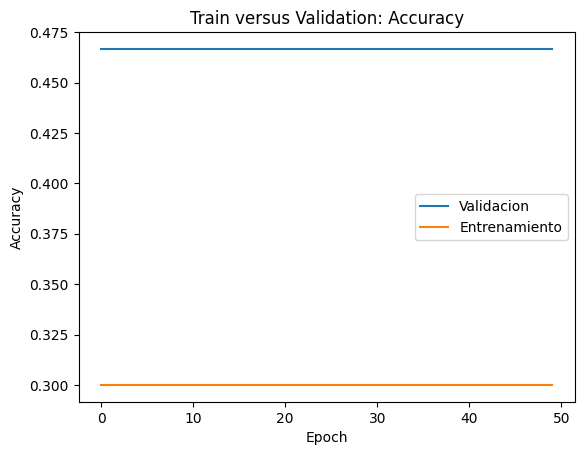

In [ ]:
sns.lineplot(x=range(num_epochs), y=accVal_list, label="Validacion")
sns.lineplot(x=range(num_epochs), y=accTrain_list, label="Entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train versus Validation: Accuracy")
plt.legend()
plt.show()

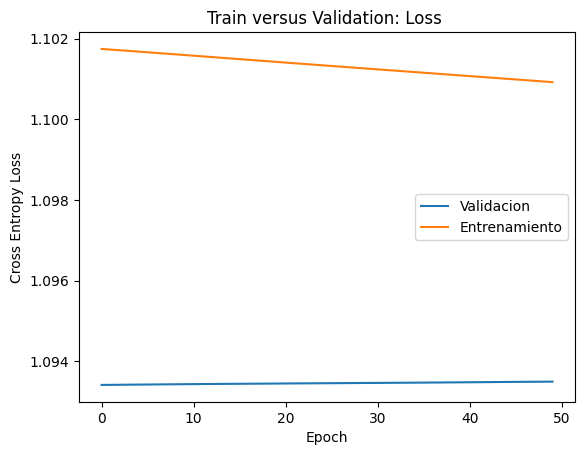

In [ ]:
sns.lineplot(x=range(num_epochs), y=lossVal_list, label="Validacion")
sns.lineplot(x=range(num_epochs), y=lossTrain_list, label="Entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Train versus Validation: Loss ")
plt.show()

¿Ha observado el comportamiento que esperaba? El optimizador SGD tiene el inconveniente de que es necesario hacer una buena selección de los parámetros para que funcione como esperaríamos. Uno de los optimizadores más usados es Adam, ya que se requiere un menor ajuste y tiene una tasa de aprendizaje adaptativa.

Repita la prueba pero usando Adam en lugar de SGD con una tasa de aprendizaje baja, como $0.001$.

100%|██████████| 100/100 [00:00<00:00, 524.40it/s]


Pérdida de entrenamiento: 0.19225293397903442
Precisión de entrenamiento: 0.949999988079071
Pérdida de validación: 0.22903962433338165
Precisión de validación: 0.9333333373069763


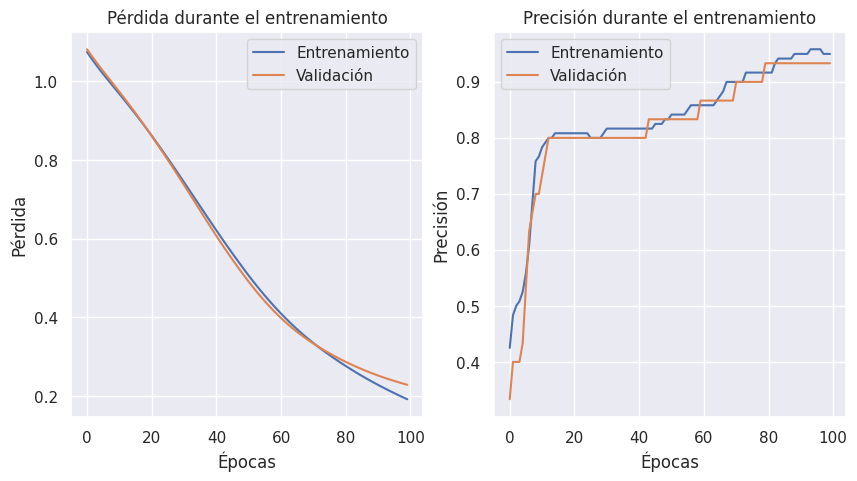

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Cargar y preparar los datos
data = load_iris()
iris = np.c_[data['data'], data['target']]

scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris[:,:-1])
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    torch.Tensor(iris_scaled), torch.Tensor(iris[:,-1]).long(), test_size=0.2, random_state=2)

# Definir el modelo
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

model = MLP(Xtrain.shape[1])

# Usar Adam con tasa de aprendizaje baja
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Tasa de aprendizaje baja
loss_fn = nn.CrossEntropyLoss()

# Función de entrenamiento
def train(modelo, X_train, y_train, X_test, y_test, epochs):
    lossTrain_list  = np.zeros((epochs,))
    accTrain_list = np.zeros((epochs,))
    lossVal_list  = np.zeros((epochs,))
    accVal_list = np.zeros((epochs,))

    for epoch in tqdm.trange(epochs):
        # Entrenamiento
        model.train()
        optimizer.zero_grad()
        Y_pred = model(X_train)
        lossTrain = loss_fn(Y_pred, y_train)
        lossTrain_list[epoch] = lossTrain.item()

        # Cálculo de precisión de entrenamiento
        correct = (torch.argmax(Y_pred, dim=1) == y_train).type(torch.FloatTensor)
        accTrain_list[epoch] = correct.mean().item()

        # Backpropagation
        lossTrain.backward()
        optimizer.step()

        # Validación
        with torch.no_grad():
            model.eval()
            Y_pred_val = model(X_test)
            lossVal = loss_fn(Y_pred_val, y_test)
            lossVal_list[epoch] = lossVal.item()

            correct_val = (torch.argmax(Y_pred_val, dim=1) == y_test).type(torch.FloatTensor)
            accVal_list[epoch] = correct_val.mean().item()

    return lossTrain_list, accTrain_list, lossVal_list, accVal_list

# Entrenamos el modelo
num_epochs = 100
lossTrain, accTrain, lossVal, accVal = train(model, Xtrain, Ytrain, Xtest, Ytest, num_epochs)

# Resultados de entrenamiento
print("Pérdida de entrenamiento:", lossTrain[-1])
print("Precisión de entrenamiento:", accTrain[-1])
print("Pérdida de validación:", lossVal[-1])
print("Precisión de validación:", accVal[-1])

# Graficar resultados (opcional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lossTrain, label='Entrenamiento')
plt.plot(lossVal, label='Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accTrain, label='Entrenamiento')
plt.plot(accVal, label='Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()


## MATRIZ DE CONFUSIÓN

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics import ConfusionMatrix

total = 0
correct = 0


X_test  = Variable(Xtest).float()
Y_test  = Variable(Ytest).long()
Y_pred = model(X_test)
correct = (torch.argmax(Y_pred, dim=1) == Y_test).type(torch.FloatTensor)
confmat = ConfusionMatrix(task="multiclass",num_classes=3)

total = Y_test.size()

print(f"Porcentaje de patrones bien clasificados: {100 *correct.mean():.2f}%")
print("Matriz de Confusion")
print(confmat(Y_pred, Y_test))



Porcentaje de patrones bien clasificados: 83.33%
Matriz de Confusion
tensor([[14,  0,  0],
        [ 0,  3,  5],
        [ 0,  0,  8]])


<ipython-input-47-92f0b455a78f>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilidades = F.softmax(self.layer3(x))


# PRÁCTICAS
1. Entrena durante más iteraciones, (100, 150) y visualiza los resultados.
2. Compara los resultados con las siguientes opciones:
  * Cambiando el número de capas ocultas (1 o 2 capas)
  * Cambiando el número de unidades ocultas (25, 100 y 500)


Tenga en cuenta que puede añadir todas las celdas que estime oportunas para poder ejecutar las distintas configuraciones.

# Modificamos el número de iteraciones a 100 y 150



In [86]:
def train(modelo, entrada, salida, epochs):
    for epoch in range(epochs):
        # 1. Reseteamos el gradiente
        optimizador.zero_grad()
        # 2. Obtenemos la salida del modelo. Propagación hacia adelante
        prediccion = modelo(entrada)
        # 3. Obtención del error
        error = f_perdida(prediccion, salida)
        # 4. Propagamos el error hacia atrás, actualizando los pesos
        error.backward()
        optimizador.step()
        if epoch % 10 == 0: # Sólo vamos a guardar una imagen cada 10 épocas
            plot_decision_boundary(modelo, entrada, salida, epoch)
    return modelo

# Cambiar epochs a 100
epochs = 100
train(perceptron, entrada, salida, epochs)

# Cambiar epochs a 150
epochs = 150
train(perceptron, entrada, salida, epochs)


Perceptron(
  (capa1): Linear(in_features=2, out_features=2, bias=True)
)

# Modificamos el número de capas ocultas


Con una capa oculta:

In [87]:
class MLP_1Capa(nn.Module):
    def __init__(self):
        super(MLP_1Capa, self).__init__()
        self.capa1 = nn.Linear(2, 8) # Capa de entrada a capa oculta
        self.activacion = nn.ReLU()
        self.capa2 = nn.Linear(8, 2) # Capa oculta a salida

    def forward(self, entrada):
        salida_capa1 = self.activacion(self.capa1(entrada))
        salida = self.capa2(salida_capa1)
        return salida

red_1capa = MLP_1Capa()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(red_1capa.parameters(), lr=0.01, momentum=0.9)
epochs = 100
train(red_1capa, entrada, salida, epochs)


MLP_1Capa(
  (capa1): Linear(in_features=2, out_features=8, bias=True)
  (activacion): ReLU()
  (capa2): Linear(in_features=8, out_features=2, bias=True)
)

Con dos capas ocultas:

In [88]:
class MLP_2Capas(nn.Module):
    def __init__(self):
        super(MLP_2Capas, self).__init__()
        self.capa1 = nn.Linear(2, 8) # Capa de entrada a capa oculta
        self.activacion = nn.ReLU()
        self.capa2 = nn.Linear(8, 8) # Capa oculta a capa oculta
        self.capa3 = nn.Linear(8, 2) # Capa oculta a salida

    def forward(self, entrada):
        salida_capa1 = self.activacion(self.capa1(entrada))
        salida_capa2 = self.activacion(self.capa2(salida_capa1))
        salida = self.capa3(salida_capa2)
        return salida

red_2capas = MLP_2Capas()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(red_2capas.parameters(), lr=0.01, momentum=0.9)
epochs = 100
train(red_2capas, entrada, salida, epochs)


MLP_2Capas(
  (capa1): Linear(in_features=2, out_features=8, bias=True)
  (activacion): ReLU()
  (capa2): Linear(in_features=8, out_features=8, bias=True)
  (capa3): Linear(in_features=8, out_features=2, bias=True)
)

# Cambiamos el número de unidades de las capas ocultas


Capa oculta con 25 unidades

In [89]:
class MLP_25Unidades(nn.Module):
    def __init__(self):
        super(MLP_25Unidades, self).__init__()
        self.capa1 = nn.Linear(2, 25) # 25 unidades en la capa oculta
        self.activacion = nn.ReLU()
        self.capa2 = nn.Linear(25, 2) # Capa oculta a salida

    def forward(self, entrada):
        salida_capa1 = self.activacion(self.capa1(entrada))
        salida = self.capa2(salida_capa1)
        return salida

red_25 = MLP_25Unidades()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(red_25.parameters(), lr=0.01, momentum=0.9)
epochs = 100
train(red_25, entrada, salida, epochs)


MLP_25Unidades(
  (capa1): Linear(in_features=2, out_features=25, bias=True)
  (activacion): ReLU()
  (capa2): Linear(in_features=25, out_features=2, bias=True)
)

Capa oculta con 100 unidades

In [90]:
class MLP_100Unidades(nn.Module):
    def __init__(self):
        super(MLP_100Unidades, self).__init__()
        self.capa1 = nn.Linear(2, 100) # 100 unidades en la capa oculta
        self.activacion = nn.ReLU()
        self.capa2 = nn.Linear(100, 2) # Capa oculta a salida

    def forward(self, entrada):
        salida_capa1 = self.activacion(self.capa1(entrada))
        salida = self.capa2(salida_capa1)
        return salida

red_100 = MLP_100Unidades()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(red_100.parameters(), lr=0.01, momentum=0.9)
epochs = 100
train(red_100, entrada, salida, epochs)


MLP_100Unidades(
  (capa1): Linear(in_features=2, out_features=100, bias=True)
  (activacion): ReLU()
  (capa2): Linear(in_features=100, out_features=2, bias=True)
)

Capa oculta con 500 unidades


In [91]:
class MLP_500Unidades(nn.Module):
    def __init__(self):
        super(MLP_500Unidades, self).__init__()
        self.capa1 = nn.Linear(2, 500) # 500 unidades en la capa oculta
        self.activacion = nn.ReLU()
        self.capa2 = nn.Linear(500, 2) # Capa oculta a salida

    def forward(self, entrada):
        salida_capa1 = self.activacion(self.capa1(entrada))
        salida = self.capa2(salida_capa1)
        return salida

red_500 = MLP_500Unidades()
f_perdida = nn.CrossEntropyLoss()
optimizador = optim.SGD(red_500.parameters(), lr=0.01, momentum=0.9)
epochs = 100
train(red_500, entrada, salida, epochs)


MLP_500Unidades(
  (capa1): Linear(in_features=2, out_features=500, bias=True)
  (activacion): ReLU()
  (capa2): Linear(in_features=500, out_features=2, bias=True)
)